# Обобщенная регрессия

## Библиотеки

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import statsmodels.api as sm
from sklearn.metrics import  auc,  accuracy_score

## Число визитов к доктору
**Cameron C. A., Trivedi P. K. Regression Analysis of Count Data. Cambridge University Press, 2013.**

Изучается функционирование системы здравоохранения Австралии. Для 1500 одиноких совершеннолетних граждан известны значения следующих показателей:

* социоэкономические:
    * пол
    * возраст, лет;
    * годовой доход, 10 тыс. долл.;
* индикаторы наличия страховки различных типов: 
    * частной, государственной для малоимущих, государственной для пожилых, инвалидов и ветеранов;
* краткосрочные характеристики здоровья:
    * число визитов к доктору за последние две недели;
    * число заболеваний за последние две недели;
    * число дней сниженной активности в связи с заболеванием или травмой за последние две недели;
* долгосрочные характеристики здоровья:
    * оценка состояния здоровья по опроснику Голдберга;
    * индикаторы наличия хронических заболеваний, ограничивающих и не ограничивающих активность.

Требуется построить модель числа визитов к доктору в зависимости от остальных признаков.

In [ ]:
data = pd.read_csv('data/dvi.txt', delimiter=' ')
data.sample(5)

In [ ]:
_ = sns.pairplot(data[['DVISITS', 'AGE', 'INCOME', 'ILLNESS', 'ACTDAYS', 'HSCORE', 'FREEPOOR']])

In [ ]:
data['FREEPOOR'].sum()

Видим, что в выборке только 59 обладателей государственной страховки для малоимущих, причём только 2 из них когда-либо ходили к врачу. Коэффициент при таком признаке будет определяться неустойчиво. Исключим эти 59 наблюдений и признак.

In [ ]:
data2 = data[data['FREEPOOR']==0]
data2.shape

Стандартная пуассоновская модель:

In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                             data=data2).fit()
model.summary2()

Показатель overdispersion/underdispersion:  ```chi2 / Df Residuals```

Отрицательная биномиальная модель:

In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+AGE+INCOME+LEVYPLUS+FREEREPA+ILLNESS+ACTDAYS+HSCORE+CHCOND1+CHCOND2',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

Удалим незначимые признаки:

In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

Попробуем возвращать по одному удалённые признаки:

In [ ]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+'
for p in ['AGE','INCOME','LEVYPLUS','FREEREPA','HSCORE','CHCOND1','CHCOND2']:
    model = sm.GLM.from_formula(formula+p, data=data2, family=sm.families.NegativeBinomial()).fit()
    print (p, model.bic)

Лучше всего модель, в которую возвращён доход:

In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

Ещё раз попробуем возвращать по одному удалённые признаки:

In [ ]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+'
for p in ['AGE','LEVYPLUS','FREEREPA','HSCORE','CHCOND1','CHCOND2']:
    model = sm.GLM.from_formula(formula+p, data=data2, family=sm.families.NegativeBinomial()).fit()
    print (p, model.bic)

Попробуем добавлять значимые межфакторные взаимодействия:

In [ ]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+'
features = ['SEX', 'ILLNESS', 'ACTDAYS', 'INCOME']
for f1 in range(len(features)):
    for f2 in range(f1+1, len(features)): 
        f1_ = features[f1]
        f2_ = features[f2]
        model = sm.GLM.from_formula(formula+str(f1_)+':'+str(f2_),
                                    data=data2, family=sm.families.NegativeBinomial()).fit()               
        for name, p in model.pvalues.items():
            if p<0.05 and ':' in name:
                print (f1_, f2_, model.bic)
                



In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS', data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

In [ ]:
model.wald_test('ILLNESS:ACTDAYS=0')

In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

Итоговая модель

In [ ]:
plt.scatter(data2['DVISITS'], model.predict(data2))
plt.ylabel('Predicted')
st.kendalltau(data2['DVISITS'], model.predict(data2))

plt.show()

Для сравнения — обычная линейная модель, не учитывающая счётную природу отклика:

In [ ]:
model2 = sm.OLS.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                             data=data2).fit()
model2.summary2()

In [ ]:
plt.scatter(data2['DVISITS'], model.predict(data2))
plt.ylabel('Predicted')
st.kendalltau(data2['DVISITS'], model.predict(data2))

plt.show()

### Финальная модель

In [ ]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

Модель позволяет сделать следующие выводы:

* При прочих равных женщины обращаются к врачу в 2 раза чаще.
* Каждый день сниженной активности без болезни увеличивает число посещений врача в 1.2 раза.
* Каждая болезнь без снижения активности увеличивает число посещений врача в 1.3 раза у женщин и 1.6 у мужчин.
* При росте на единицу одновременно числа дней сниженной активности и числа заболеваний число визитов к доктору растёт в 1.03 медленнее, чем если бы эти признаки действовали независимо.
* Увеличение годового дохода на 10 тыс. долл. снижает среднее число визитов к врачу в 1.4 раза.



## Риск остеопороза у женщин
**Global Longitudinal Study of Osteoporosis in Women (выборка по Hosmer D.W., Lemeshow S., Sturdivant R.X. Applied logistic regression. — Hoboken: John Wiley & Sons, 2013, 1.6.3.)**

Для 500 участниц исследования Global Longitudinal Study of Osteoporosis in Women (Center for Outcomes Research, the University of Massachusetts/Worcester) измерены следующие показатели:

* возраст, лет (не меньше 55);
* вес, кг;
* рост, см;
* ИМТ, кг/см2;
* бинарные признаки: курение, индикатор наступления менопаузы до 45 лет, индикатор необходимости помощи при подъёме из сидячего положения, перелом шейки бедра в прошлом (был/не было), перелом шейки бедра у матери (был/не было);
* самостоятельная субъективная оценка вероятности перелома (меньше/такая же/больше, чем у сверстниц).

Известно, у кого из участниц в первый год исследования произошёл перелом шейки бедра. Необходимо построить модель вероятности перелома с учётом имеющихся признаков.




In [ ]:
data = pd.read_csv('data/GLOW500.txt', delimiter='\t')
data.head()

In [ ]:
_ = sns.pairplot(data, hue='FRACTURE')

Проверим разделимость классов по категориальным предикторам:

In [ ]:
predictors = ['SMOKE', 'PREMENO', 'ARMASSIST', 'PRIORFRAC', 'RATERISK']
for k in predictors:
    print (data.groupby([k, 'FRACTURE']).size(),'\n\n')
    



Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [ ]:
predictors = list(data.columns)
predictors.remove('FRACTURE')

for p in predictors:
    model = sm.GLM.from_formula('FRACTURE~'+str(p), data=data, family=sm.families.Binomial()).fit()
    print (model.summary2())

Многомерная модель со всеми значимыми предикторами:

In [ ]:
model = sm.GLM.from_formula('FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISK',
                            data=data, family=sm.families.Binomial()).fit()
model.summary2()

Критерий Вальда считает модель существенно лучше константы:

In [ ]:
model.wald_test('AGE=HEIGHT=PRIORFRAC[T.yes]=MOMFRAC[T.yes]=ARMASSIST[T.yes]=RATERISK[T.less]=RATERISK[T.same]=0')

Попробуем полностью или частично удалить RATERISK


In [ ]:
model.wald_test('RATERISK[T.less]=RATERISK[T.same]=0')

In [ ]:
model.wald_test('RATERISK[T.less]=0')

Оставим в модели RATERISKless — модель с ним значимо лучше, чем без него.

Попробуем возвращать в модель удалённые признаки:



In [ ]:
def RATERISKless(x):
    return (x=='less')

model = sm.GLM.from_formula('FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST +  RATERISKless(RATERISK)',
                            data=data, family=sm.families.Binomial()).fit()
model.summary2()




In [ ]:
print ('ORIGINAL', (model.llf))
formula = 'FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)'
predictors2 = ['PRIORFRAC','WEIGHT', 'BMI', 'PREMENO', 'SMOKE']
for f in predictors2:
    formula2 =formula +'+'+f
    model2 = sm.GLM.from_formula(formula2,
                            data=data, family=sm.families.Binomial()).fit()
    print (f, model2.llf)

Проверим линейность логита по непрерывным признакам. Сглаженные диаграммы рассеяния: 

In [ ]:
probs = model.predict(data)
odds = probs/(1-probs)
_ = sns.regplot(data['AGE'], np.log(odds), order=2, scatter=True,scatter_kws={'alpha':0.05},line_kws={'alpha':0.9})

Попробуем добавить к модели признак AGE ≥ 80:



In [ ]:
model2 = sm.GLM.from_formula('FRACTURE ~ AGE + AGE>=80 + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)',
                            data=data, family=sm.families.Binomial()).fit()
model2.summary2()



Ничего лучше линейной модели подобрать не удалось.

Рассмотрим теперь все модели, в которые добавлено одно межфакторное взаимодействие:

In [ ]:
formula = 'FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)'
predictors = list(data.columns)
predictors.remove('FRACTURE')
for f1 in predictors:
    for f2 in predictors:
        formula2 =formula +'+{0}*{1}'.format(f1,f2)
        model2 = sm.GLM.from_formula(formula2,
                                data=data, family=sm.families.Binomial()).fit()
        for name, p in model2.pvalues.items():
            if p<0.05 and ':' in name:
                print (name,p)



Добавим все три межфакторных взаимодействия с p-value на уровне 0.025:

In [ ]:
model3 = sm.GLM.from_formula("""FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK) +
                             +AGE:PRIORFRAC + MOMFRAC:ARMASSIST""",
                             data=data,  family=sm.families.Binomial()).fit()
model3.summary2()

Получается значимо лучше.

Посмотрим графики качества классификации: 

In [ ]:
tp, tn = [],[]
fp, fn = [], []
labels = (data['FRACTURE']=='no')*1.0
probas = model3.predict(data)
thresholds = np.arange(0,1.0,0.05)
for t in thresholds:
    tp_ = (probas[labels==1]>=t)
    tn_ = (probas[labels==0]<t)
    fp_ = (probas[labels==0]>=t)
    fn_ = (probas[labels==1]<t)
    
    tp.append(tp_)
    tn.append(tn_)
    fp.append(fp_)
    fn.append(fn_)

In [ ]:
plt.plot(list(map(np.mean, fp)), list(map(np.mean, tp)))
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc(list(map(np.mean, fp)), list(map(np.mean, tp))))



In [ ]:
plt.plot(thresholds, list(map(np.mean, tp)),  label='Sensitivity')
plt.plot(thresholds, list(map(np.mean, tn)), label='Specificity')
plt.legend(loc='best')

plt.grid()
plt.show()

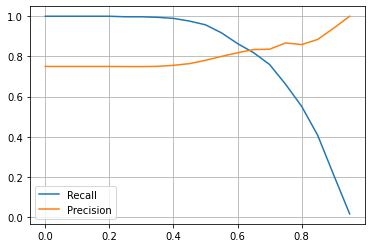

In [37]:
plt.plot(thresholds, list(map(np.mean, tp)), label='Recall')

prec = [tp_.sum()/(tp_.sum()+fp_.sum()) for tp_, fp_ in zip(tp, fp)]
plt.plot(thresholds, prec, label='Precision')

plt.legend(loc='best')
plt.grid()
plt.show()

При пороге 0.75 построенная модель обеспечивает чувствительность 0.7 и специфичность 0.7; площадь под ROC-кривой составляет 0.72.`

Модель позволяет сделать следующие выводы:

* для женщин, с которыми уже случался перелом шейки бедра, риск нового перелома в течение года существенно выше (в 110);
* каждые десять лет относительный риск перелома шейки бедра у женщин, с которыми он ещё не происходил, возрастает в 1.8 раз; при этом для женщин, у которых уже был перелом, увеличение возраста не приносит дополнительного значимого увеличения риска перелома (мультипликативный прирост риска за 10 лет 1.01);
* при прочих равных для женщин маленького роста риск перелома выше — на каждые 10 сантиметров уменьшения роста приходится увеличение риска перелома в 1.5 раз;
* для женщин, у матерей которых не было перелома шейки бедра, неспособность самостоятельно вставать из сидячего положения связана с повышением риска перелома в 1.9 раз;
* для женщин, которые способны самостоятельно вставать из сидячего положения, наличие перелома у матери связано с повышением риска перелома в 3.3 раз;
* женщины, оценивающие вероятность своего перелома как низкую, действительно при прочих равных имеют шанс перелома ниже в 1.7 раз.